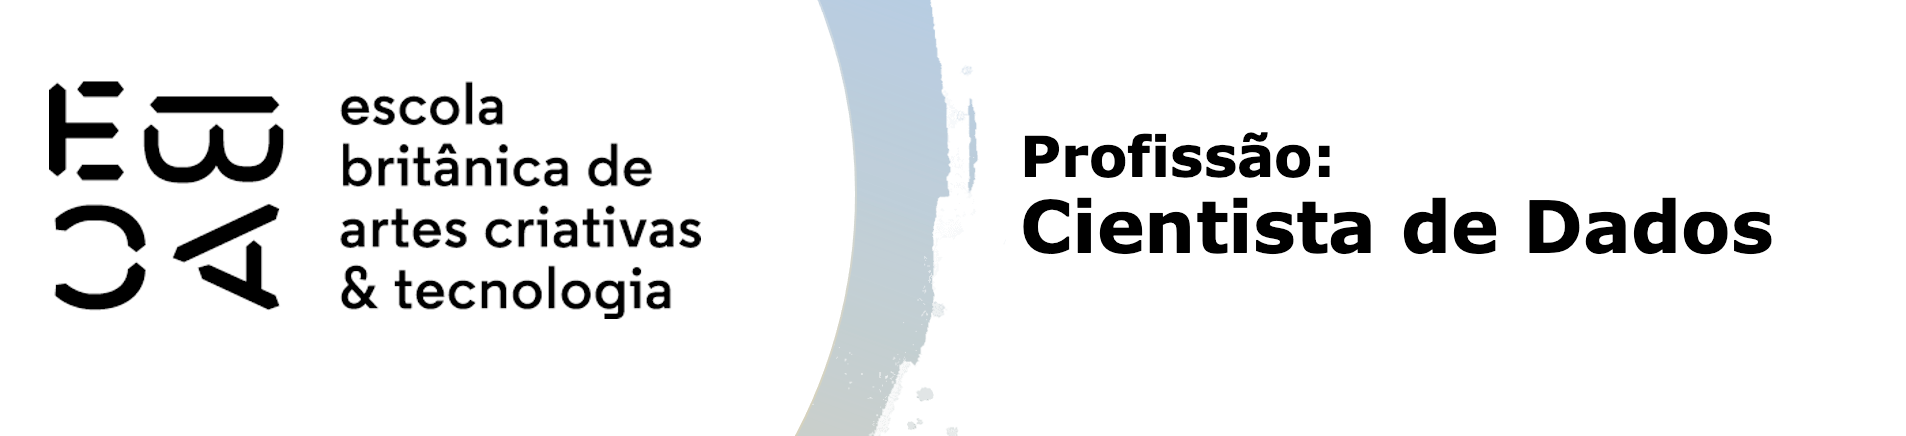

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('../34 - Regressão III/previsao_de_renda_II.csv')

mean_temp_empreg = df['tempo_emprego'].mean()
df['tempo_emprego'] = df['tempo_emprego'].fillna(mean_temp_empreg)
df['cat_tempo_emprego'], quebras = pd.qcut(df.tempo_emprego, 20, labels = False,
                        duplicates='drop', retbins=True)
df['log_renda'] = np.log(df['renda'])
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16,9.318131
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,13,7.793508
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,12,9.528769
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1,7.767196
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1,6.673020


In [2]:
df_train = df.loc[df['data_ref'] <= '2015-12-01']
df_test = df.loc[df['data_ref'] > '2015-12-01']

In [3]:
print(df_train.shape)
print(df_test.shape)
print(df.shape)

(600000, 16)
(150000, 16)
(750000, 16)


In [4]:
df_train1 = df_train.sample(frac=0.01, replace=False, random_state=2018)
df_train1 = df_train1.sort_values('data_ref',ascending=True).reset_index(drop=True)

df_test1 = df_test.sample(frac=0.01, replace=False, random_state=2018)
df_test1 = df_test1.sort_values('data_ref',ascending=True).reset_index(drop=True)

print(df_train1.shape)
print(df_test1.shape)

#OBS: realizei esta redução do tamanho do DataFrame, para agilizar o processamento da análise do studentized residuals e
# dos pontos influentes, pois ao realizar sobre a base cheia, passados 3 horas, o meu micro ainda não havia processado o comando. 

(6000, 16)
(1500, 16)


In [5]:
quebras

array([ 0.11780822,  0.81643836,  1.45753425,  2.09863014,  2.91232877,
        3.63561644,  4.30136986,  4.93424658,  5.75890411,  6.62191781,
        7.47123288,  7.7461648 ,  8.10684932,  9.09315068, 10.43835616,
       12.4739726 , 15.21643836, 20.21643836, 42.90684932])

In [6]:
%%time
res_quebras = smf.ols('''log_renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade +
    cat_tempo_emprego + qt_pessoas_residencia + C(sexo) + C(tipo_renda) + C(educacao) +
    C(estado_civil) + C(tipo_residencia)''', data = df_train1).fit()

print(res_quebras.rsquared_adj)
res_quebras.summary()

0.357069304087821
CPU times: user 249 ms, sys: 7.51 ms, total: 256 ms
Wall time: 259 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:59:15   Log-Likelihood:                -8366.5
No. Observations:                6000   AIC:                         1.678e+04
Df Residuals:                    5975   BIC:                         1.695e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.4815      0.817      7.930      0.000       4.879       8.084
posse_de_veiculo[T.S]                   0.0060      0.029      0.209      0.835      -0.050       0.062
posse_de_imovel[T.S]                    0.1943      0.028      7.027      0.000       0.140       0.249
C(sexo)[T.M]                            0.1342      0.030      4.470      0.000       0.075       0.193
C(tipo_renda)[T.Bolsista]              -1.2775      0.692     -1.845      0.065      -2.635       0.080
C(tipo_renda)[T.Empresário]             0.1620      0.032      5.078      0.000       0.099       0.224
C(tipo_renda)[T.Pensionista]           -0.6122      0.045    -13.611      0.000      -0.700      -0.524
C(tipo_renda)[T.Servidor público]       0.1670      0.048      3.504      0.000       0.074       0.260
C(educacao)[T.Médio]                    0.2108      0.117      1.802      0.072      -0.019       0.440
C(educacao)[T.Pós graduação]            0.3757      0.388      0.968      0.333      -0.385       1.137
C(educacao)[T.Superior completo]        0.3450      0.118      2.915      0.004       0.113       0.577
C(educacao)[T.Superior incompleto]      0.2713      0.132      2.048      0.041       0.012       0.531
C(estado_civil)[T.Separado]             0.3881      0.405      0.959      0.337      -0.405       1.181
C(estado_civil)[T.Solteiro]             0.4435      0.401      1.107      0.268      -0.342       1.229
C(estado_civil)[T.União]                0.0289      0.048      0.598      0.550      -0.066       0.124
C(estado_civil)[T.Viúvo]                0.3600      0.406      0.887      0.375      -0.436       1.156
C(tipo_residencia)[T.Casa]             -0.0682      0.111     -0.616      0.538      -0.285       0.149
C(tipo_residencia)[T.Com os pais]      -0.0087      0.127     -0.068      0.946      -0.258       0.240
C(tipo_residencia)[T.Comunitário]      -0.1375      0.205     -0.669      0.503      -0.540       0.265
C(tipo_residencia)[T.Estúdio]          -0.2794      0.199     -1.401      0.161      -0.670       0.112
C(tipo_residencia)[T.Governamental]    -0.0454      0.129     -0.353      0.724      -0.298       0.207
qtd_filhos                             -0.3560      0.401     -0.887      0.375      -1.143       0.431
idade                                   0.0113      0.002      6.819      0.000       0.008       0.015
cat_tempo_emprego                       0.1405      0.003     51.916      0.000       0.135       0.146
qt_pessoas_residencia                   0.3659      0.401      0.913      0.362      -0.420       1.152
==============================================================================
Omnibus:                       22.558   Durbin-Watson:                   1.308
Prob(Omnibus)

In [7]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(res_quebras.fittedvalues)
df_ajuste_rsquared['y'] = df_train1['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.3771163068197032

In [8]:
res_quebras_test = smf.ols('''log_renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade +
    cat_tempo_emprego + qt_pessoas_residencia + C(sexo) + C(tipo_renda) + C(educacao) +
    C(estado_civil) + C(tipo_residencia)''', data = df_test1).fit()

print(res_quebras.rsquared_adj)
res_quebras.summary()

0.357069304087821


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        09:59:23   Log-Likelihood:                -8366.5
No. Observations:                6000   AIC:                         1.678e+04
Df Residuals:                    5975   BIC:                         1.695e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.4815      0.817      7.930      0.000       4.879       8.084
posse_de_veiculo[T.S]                   0.0060      0.029      0.209      0.835      -0.050       0.062
posse_de_imovel[T.S]                    0.1943      0.028      7.027      0.000       0.140       0.249
C(sexo)[T.M]                            0.1342      0.030      4.470      0.000       0.075       0.193
C(tipo_renda)[T.Bolsista]              -1.2775      0.692     -1.845      0.065      -2.635       0.080
C(tipo_renda)[T.Empresário]             0.1620      0.032      5.078      0.000       0.099       0.224
C(tipo_renda)[T.Pensionista]           -0.6122      0.045    -13.611      0.000      -0.700      -0.524
C(tipo_renda)[T.Servidor público]       0.1670      0.048      3.504      0.000       0.074       0.260
C(educacao)[T.Médio]                    0.2108      0.117      1.802      0.072      -0.019       0.440
C(educacao)[T.Pós graduação]            0.3757      0.388      0.968      0.333      -0.385       1.137
C(educacao)[T.Superior completo]        0.3450      0.118      2.915      0.004       0.113       0.577
C(educacao)[T.Superior incompleto]      0.2713      0.132      2.048      0.041       0.012       0.531
C(estado_civil)[T.Separado]             0.3881      0.405      0.959      0.337      -0.405       1.181
C(estado_civil)[T.Solteiro]             0.4435      0.401      1.107      0.268      -0.342       1.229
C(estado_civil)[T.União]                0.0289      0.048      0.598      0.550      -0.066       0.124
C(estado_civil)[T.Viúvo]                0.3600      0.406      0.887      0.375      -0.436       1.156
C(tipo_residencia)[T.Casa]             -0.0682      0.111     -0.616      0.538      -0.285       0.149
C(tipo_residencia)[T.Com os pais]      -0.0087      0.127     -0.068      0.946      -0.258       0.240
C(tipo_residencia)[T.Comunitário]      -0.1375      0.205     -0.669      0.503      -0.540       0.265
C(tipo_residencia)[T.Estúdio]          -0.2794      0.199     -1.401      0.161      -0.670       0.112
C(tipo_residencia)[T.Governamental]    -0.0454      0.129     -0.353      0.724      -0.298       0.207
qtd_filhos                             -0.3560      0.401     -0.887      0.375      -1.143       0.431
idade                                   0.0113      0.002      6.819      0.000       0.008       0.015
cat_tempo_emprego                       0.1405      0.003     51.916      0.000       0.135       0.146
qt_pessoas_residencia                   0.3659      0.401      0.913      0.362      -0.420       1.152
==============================================================================
Omnibus:                       22.558   Durbin-Watson:                   1.308
Prob(Omnibus)

In [9]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(res_quebras_test.fittedvalues)
df_ajuste_rsquared['y'] = df_test1['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.5058592010158154

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

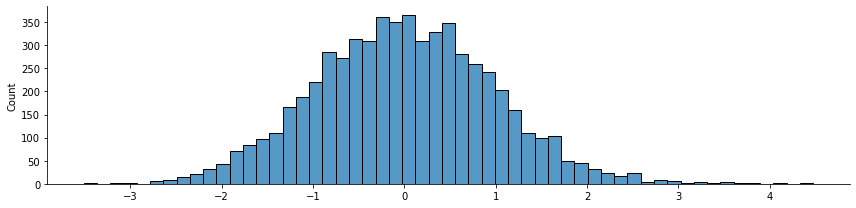

In [10]:
# Análise da suposição do modelo quando a sua distribuição (se é normal ou não)

sns.displot(res_quebras.resid, height=3, aspect=4);

#### Os resíduos deste modelo possui distribuição normal #### 

<AxesSubplot:>

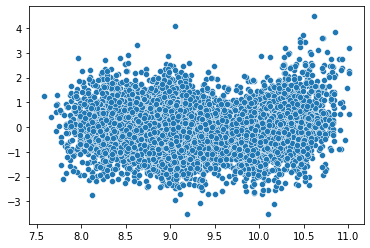

In [9]:
# Verificando a independência dos resíduos

# Gráfico dos resíduos versus os valores preditos

sns.scatterplot(x = res_quebras.predict(), y = res_quebras.resid)
    

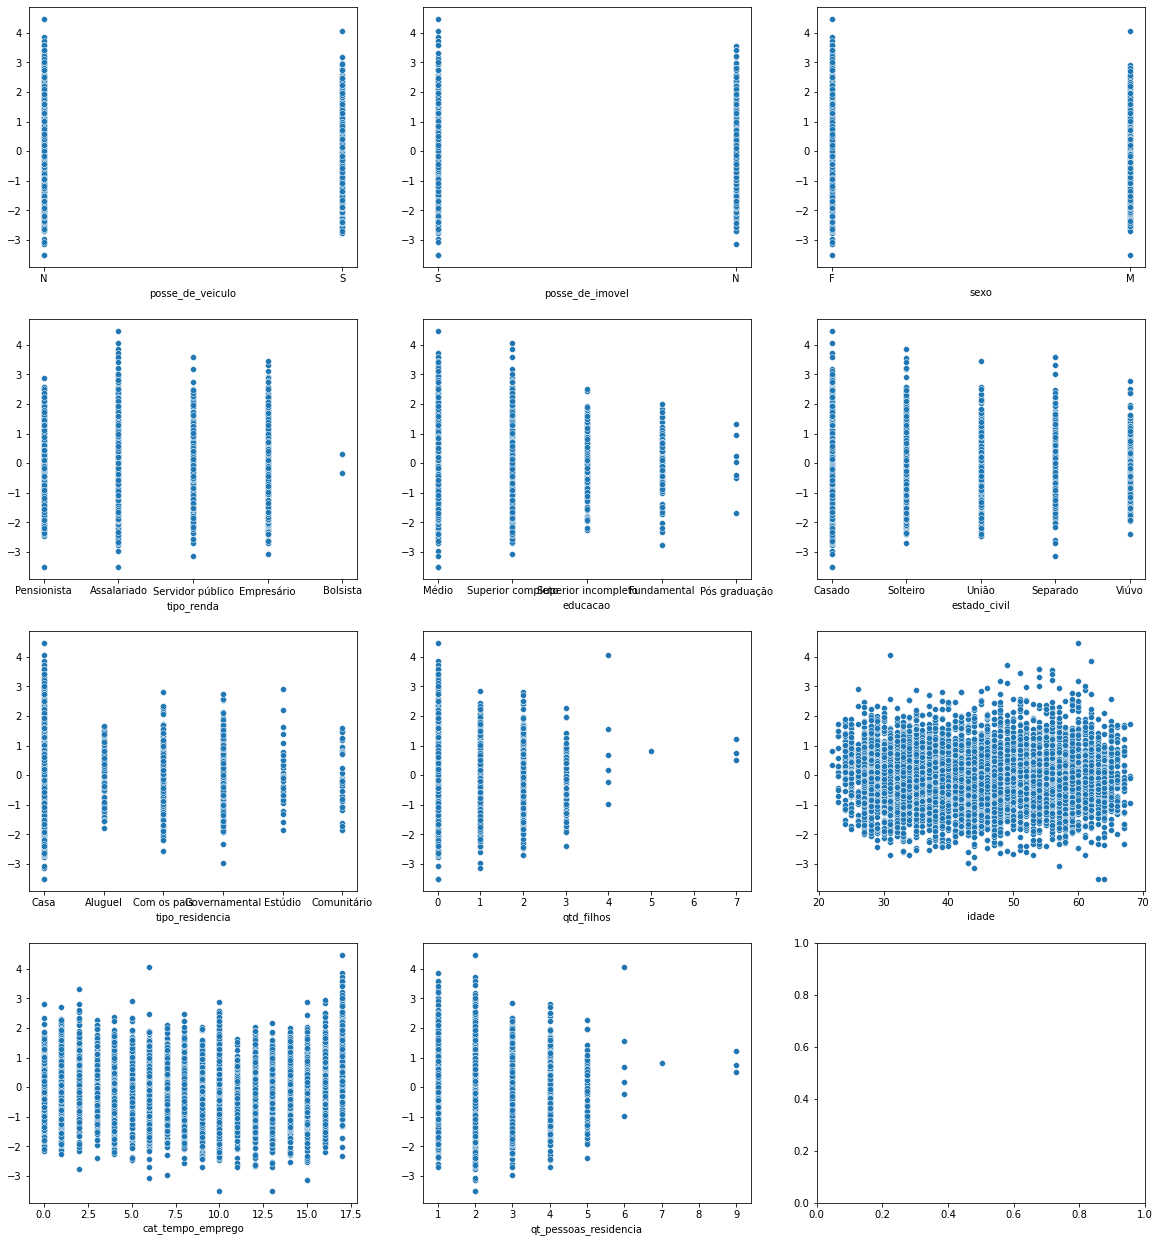

In [10]:

#Avaliando se há padrões dos resíduos versus cada uma das variáveis do modelo

plt.rc('figure', figsize=(20,22))
fig, axes = plt.subplots(4,3)
sns.scatterplot(ax=axes[0,0], x = df_train1.posse_de_veiculo, y = res_quebras.resid)
sns.scatterplot(ax=axes[0,1], x = df_train1.posse_de_imovel, y = res_quebras.resid)
sns.scatterplot(ax=axes[0,2], x = df_train1.sexo, y = res_quebras.resid)
sns.scatterplot(ax=axes[1,0], x = df_train1.tipo_renda, y = res_quebras.resid)
sns.scatterplot(ax=axes[1,1], x = df_train1.educacao, y = res_quebras.resid)
sns.scatterplot(ax=axes[1,2], x = df_train1.estado_civil, y = res_quebras.resid)
sns.scatterplot(ax=axes[2,0], x = df_train1.tipo_residencia, y = res_quebras.resid)
sns.scatterplot(ax=axes[2,1], x = df_train1.qtd_filhos, y = res_quebras.resid)
sns.scatterplot(ax=axes[2,2], x = df_train1.idade, y = res_quebras.resid)
sns.scatterplot(ax=axes[3,0], x = df_train1.cat_tempo_emprego, y = res_quebras.resid)
sns.scatterplot(ax=axes[3,1], x = df_train1.qt_pessoas_residencia, y = res_quebras.resid);

As variáveis não apresentaram um padrão frente aos seus resíduos.

In [11]:

#avaliando se o valor médio dos resíduos aparenta alguma relação com o mês de referência.

resid_mean = pd.DataFrame()
resid_mean['data_ref'] = df_train1['data_ref']
resid_mean['resid'] = res_quebras.resid
resid_mean1 = resid_mean.groupby('data_ref')['resid'].mean()
resid_mean1

data_ref
2015-01-01   -0.931433
2015-02-01   -0.690770
2015-03-01   -0.374846
2015-04-01    0.084820
2015-05-01    0.462650
2015-06-01    0.682036
2015-07-01    0.756952
2015-08-01    0.688517
2015-09-01    0.366313
2015-10-01    0.026657
2015-11-01   -0.306008
2015-12-01   -0.656635
Name: resid, dtype: float64

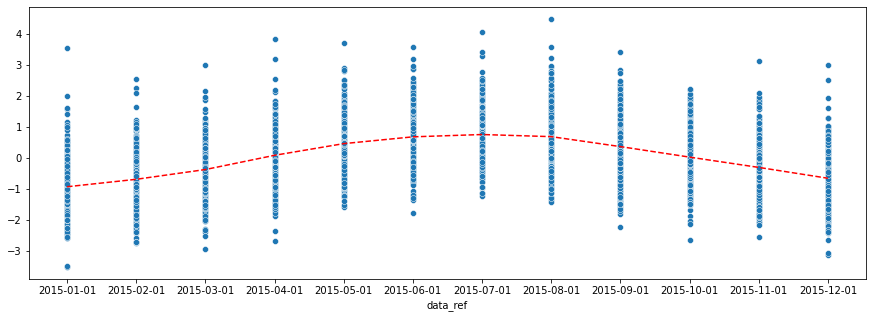

In [12]:
plt.rc('figure', figsize=(15,5))
sns.scatterplot(x = df_train1.data_ref, y = res_quebras.resid)
plt.plot(resid_mean1, 'r--')
plt.show();

A média dos resíduos segue um padrão em releção aos resíduos dos meses de referência. Ou seja, nos meses em que houveram resíduos mais negativos, a média tendeu ao negativo. Nos meses com resíduos maiores, houve aumento também em sua média. Enfim, apresentou um padrão.

<AxesSubplot:ylabel='log_renda'>

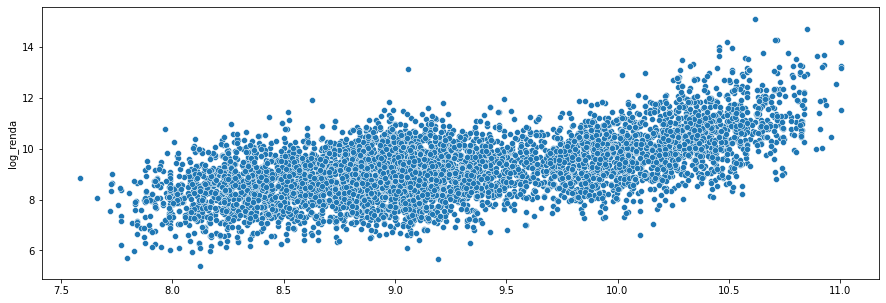

In [13]:

# Avaliando se a variância da variável resposta parece ser conforme os valores previstos.

sns.scatterplot(x = res_quebras.predict(), y = df_train1.log_renda)

Entendo que as suposições foram atendidas.
A independência está demonstrada com os gráficos dos resíduos com cada uma das variáveis e o gráfico de resíduo versus valores preditos, ou seja, os resíduos ($\epsilon_{i}$) são independentes entre si. O gráfico de barras referente aos resíduos demonstram uma distribuição normal. Já o gráfico resíduo versus os valores preditos e o gráfico variável resposta versus valores preditos versus demonstram a homocedasticidade. Frise-se que o log na variável resposta contribui para a honocedasticidade (proximidade nas variâncias dos resíduos (epsilon = $\epsilon_{i}$ = variância do y residual).

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

CPU times: user 741 ms, sys: 2.96 ms, total: 744 ms
Wall time: 404 ms


<AxesSubplot:xlabel='tempo_emprego', ylabel='log_renda'>

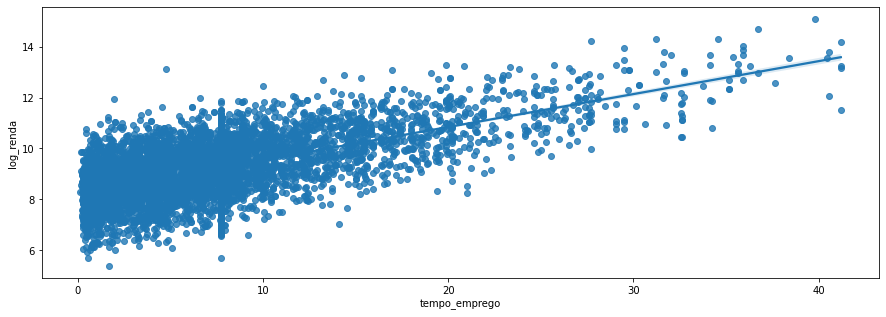

In [14]:
%%time
fig, ax = plt.subplots()
sns.regplot(x = 'tempo_emprego', y = 'log_renda', data=df_train1, ax=ax);

CPU times: user 802 ms, sys: 3.96 ms, total: 806 ms
Wall time: 428 ms


<AxesSubplot:xlabel='idade', ylabel='log_renda'>

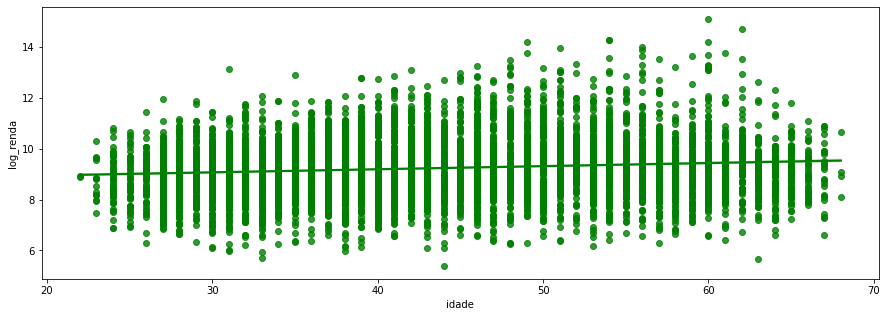

In [15]:
%%time
fig, ax = plt.subplots()
sns.regplot(x = 'idade', y = 'log_renda', data=df_train1, ax=ax, color="g");

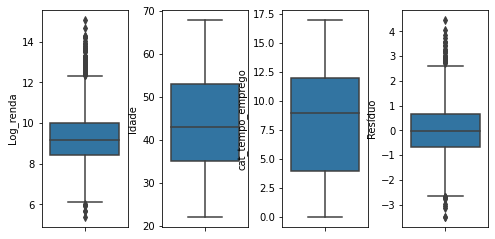

In [16]:
fix, ax = plt.subplots(1, 4, figsize=(8,4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y = 'log_renda',data=df_train1, ax=ax[0])
sns.boxplot(y = 'idade',data=df_train1, ax=ax[1])
sns.boxplot(y = 'cat_tempo_emprego',data=df_train1, ax=ax[2])
sns.boxplot(y = res_quebras.resid ,data=df_train1, ax=ax[3]);

ax[0].set_ylabel('Log_renda')
ax[1].set_ylabel('Idade')
ax[2].set_ylabel('cat_tempo_emprego')
ax[3].set_ylabel('Resíduo');

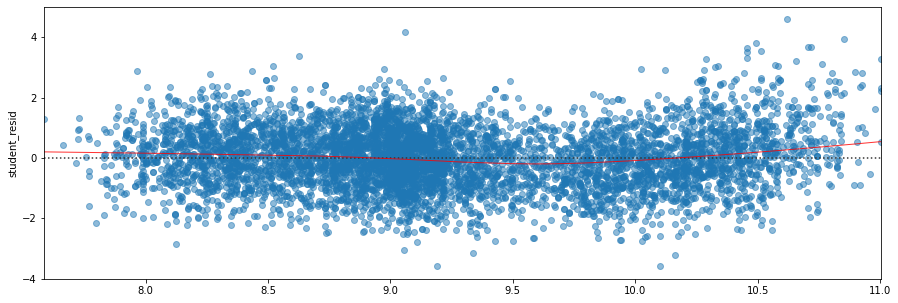

In [17]:
st_res= res_quebras.outlier_test()
sns.residplot(x=res_quebras.predict(), y=st_res.student_resid, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

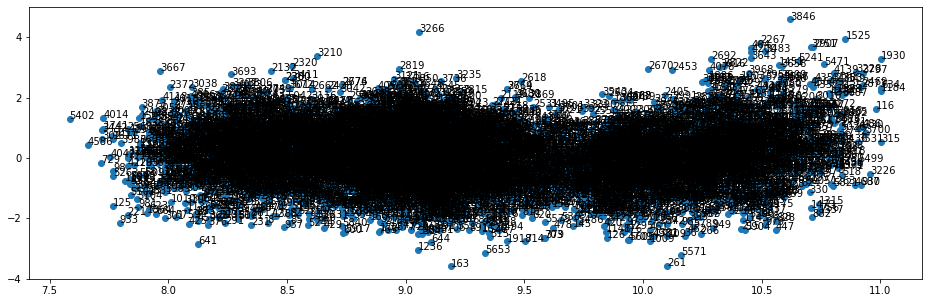

In [18]:
fig, ax = plt.subplots(figsize=(16,5))

ax.scatter(x = res_quebras.predict(), y = st_res.student_resid)

for i, txt in enumerate(df_train1.index.values):
    ax.annotate(str(txt), (res_quebras.predict()[i], st_res.student_resid[i]))

plt.show()

CPU times: user 1min, sys: 340 ms, total: 1min 1s
Wall time: 30.9 s


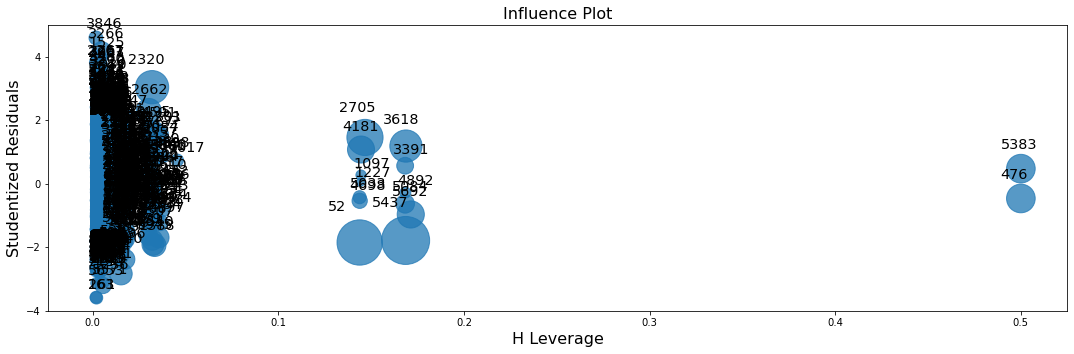

In [19]:
%%time

fig = sm.graphics.influence_plot(res_quebras, criterion="cooks")
fig.tight_layout(pad=1.0)

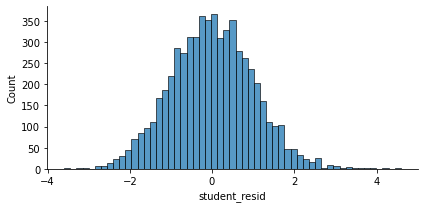

In [20]:
sns.displot(st_res.student_resid, height=3, aspect=2);

In [11]:
df_train1.loc[5383:5383] # Incoerente - Bolsista, Superior Completo com 51 anos

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
5383,2015-11-01,590,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,10678.29,14,9.275968


In [12]:
df_train1.loc[476:476] # Incoerente - Bolsista com Sueprior Completo e 51 anos 

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
476,2015-01-01,590,F,N,S,0,Bolsista,Superior completo,Casado,Casa,51,10.69589,2.0,5581.69,14,8.627247


In [15]:
df_train1.loc[5437:5437] # Incoerente - Solteiro,s/ filho e 2 pessoas morando juntos

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
5437,2015-11-01,16587,M,S,S,0,Assalariado,Superior completo,Solteiro,Casa,48,8.265753,2.0,7337.14,12,8.900704


In [14]:
df_train1.loc[4892:4892] # Incoerente - Solteiro,s/ filho e 2 pessoas morando juntos


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
4892,2015-10-01,16480,M,N,S,0,Assalariado,Médio,Solteiro,Casa,46,0.679452,2.0,4429.93,0,8.396139


In [18]:
df_train1.loc[3618:3618] # Incoerente - Solteiro, s/ filhos e 2 pessoas na residência

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
3618,2015-08-01,16588,F,N,N,0,Empresário,Médio,Solteiro,Casa,53,15.841096,2.0,141870.2,16,11.862668


In [20]:

df_train1.loc[3391:3391] # Incoerente - Solteiro, s/ filhos e 2 pessoas na residência

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
3391,2015-07-01,16505,M,S,N,0,Servidor público,Médio,Solteiro,Casa,55,4.235616,2.0,20596.19,5,9.932861


In [17]:
df_train1.loc[52:52] # Coerente

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
52,2015-01-01,15168,M,S,S,0,Assalariado,Pós graduação,Casado,Casa,61,0.534247,2.0,961.19,0,6.868172


In [19]:
df_train1.loc[2705:2705] # Coerente

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
2705,2015-06-01,818,F,N,S,1,Assalariado,Pós graduação,União,Casa,47,20.70411,3.0,160430.86,17,11.985618


In [63]:
df_train1.loc[5692:5692] # Incoerente - um filho, solteira, mas 1 pessoa na residencia

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
5692,2015-12-01,16644,F,N,S,1,Assalariado,Superior completo,Solteiro,Casa,34,3.10137,1.0,1784.97,4,7.487157


In [69]:
df_train1.loc[5084:5084] # incoerente, s/ filhos, solteira, qt pessoas residencia 2.

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_tempo_emprego,log_renda
5084,2015-11-01,16505,M,S,N,0,Servidor público,Médio,Solteiro,Casa,55,4.235616,2.0,7067.77,5,8.8633


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [11]:
import scipy.stats as ss 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [28]:
variaveis = ['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 
            'cat_tempo_emprego', 'qt_pessoas_residencia', 'sexo', 'tipo_renda','educacao', 
            'estado_civil', 'tipo_residencia', 'log_renda']

In [29]:
#Matriz de correlação de Spearman

df_train1[variaveis].corr(method='spearman')

,qtd_filhos,idade,cat_tempo_emprego,qt_pessoas_residencia,log_renda
qtd_filhos,1.000000,-0.431310,-0.107462,0.829977,-0.023453
idade,-0.431310,1.000000,0.289701,-0.368235,0.102339
cat_tempo_emprego,-0.107462,0.289701,1.000000,-0.077867,0.536135
qt_pessoas_residencia,0.829977,-0.368235,-0.077867,1.000000,-0.009211
log_renda,-0.023453,0.102339,0.536135,-0.009211,1.000000


In [8]:
# VIF (Variance Inflacion Factor)

variaveis = ['posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'idade', 
            'cat_tempo_emprego', 'qt_pessoas_residencia', 'sexo', 'tipo_renda','educacao', 
            'estado_civil', 'tipo_residencia']

In [10]:

df_train1_dum = pd.get_dummies(df_train1[variaveis], drop_first=True)
df_train1_dum.head()

,qtd_filhos,idade,cat_tempo_emprego,qt_pessoas_residencia,posse_de_veiculo_S,posse_de_imovel_S,sexo_M,tipo_renda_Bolsista,tipo_renda_Empresário,tipo_renda_Pensionista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,58,10,2.0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,44,3,2.0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,33,13,1.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,42,12,1.0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,2,27,2,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [16]:
vif(df_train1_dum, 10)

1.2180066402870133

In [20]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_train1_dum, i) for i in range(df_train1_dum.shape[1])]
vars_vif["Feature"] = df_train1_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,38.63,qtd_filhos
1,35.56,idade
2,4.49,cat_tempo_emprego
3,265.53,qt_pessoas_residencia
4,2.01,posse_de_veiculo_S
5,3.21,posse_de_imovel_S
6,1.83,sexo_M
7,1.00,tipo_renda_Bolsista
8,1.48,tipo_renda_Empresário
9,2.18,tipo_renda_Pensionista


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [12]:
#Ajuste no modelo excluindo os outliers

df_train2 = df_train1.drop([5383, 476, 5437, 4892, 3618, 3391, 5692, 5084], axis=0) 

In [13]:
print(df_train2.shape)
print(df_train1.shape)

(5992, 16)
(6000, 16)


In [14]:
reg_outliers = smf.ols('''log_renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade +
    cat_tempo_emprego + qt_pessoas_residencia + C(sexo) + C(tipo_renda) + C(educacao) +
    C(estado_civil) + C(tipo_residencia)''', data = df_train2).fit()

print(reg_outliers.rsquared_adj)
reg_outliers.summary()

0.3570255261184959


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:00:47   Log-Likelihood:                -8356.6
No. Observations:                5992   AIC:                         1.676e+04
Df Residuals:                    5969   BIC:                         1.691e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.0257      0.100     40.395      0.000       3.830       4.221
posse_de_veiculo[T.S]                   0.0064      0.029      0.222      0.824      -0.050       0.062
posse_de_imovel[T.S]                    0.1955      0.028      7.066      0.000       0.141       0.250
C(sexo)[T.M]                            0.1352      0.030      4.503      0.000       0.076       0.194
C(tipo_renda)[T.Empresário]             0.1601      0.032      5.017      0.000       0.098       0.223
C(tipo_renda)[T.Pensionista]           -0.6129      0.045    -13.625      0.000      -0.701      -0.525
C(tipo_renda)[T.Servidor público]       0.1662      0.048      3.481      0.001       0.073       0.260
C(educacao)[T.Médio]                    0.2108      0.117      1.802      0.072      -0.019       0.440
C(educacao)[T.Pós graduação]            0.3754      0.388      0.967      0.334      -0.386       1.137
C(educacao)[T.Superior completo]        0.3466      0.118      2.929      0.003       0.115       0.579
C(educacao)[T.Superior incompleto]      0.2716      0.132      2.050      0.040       0.012       0.531
C(estado_civil)[T.Separado]             1.6153      0.061     26.301      0.000       1.495       1.736
C(estado_civil)[T.Solteiro]             1.6730      0.050     33.677      0.000       1.576       1.770
C(estado_civil)[T.União]                0.0293      0.048      0.604      0.546      -0.066       0.124
C(estado_civil)[T.Viúvo]                1.5874      0.070     22.807      0.000       1.451       1.724
C(tipo_residencia)[T.Casa]             -0.0677      0.111     -0.612      0.541      -0.285       0.149
C(tipo_residencia)[T.Com os pais]      -0.0084      0.127     -0.066      0.947      -0.258       0.241
C(tipo_residencia)[T.Comunitário]      -0.1379      0.205     -0.671      0.502      -0.541       0.265
C(tipo_residencia)[T.Estúdio]          -0.2795      0.199     -1.401      0.161      -0.671       0.112
C(tipo_residencia)[T.Governamental]    -0.0447      0.129     -0.347      0.729      -0.297       0.208
qtd_filhos                             -1.5829      0.047    -34.006      0.000      -1.674      -1.492
idade                                   0.0113      0.002      6.824      0.000       0.008       0.015
cat_tempo_emprego                       0.1404      0.003     51.850      0.000       0.135       0.146
qt_pessoas_residencia                   1.5928      0.040     39.336      0.000       1.513       1.672
==============================================================================
Omnibus:                       22.499   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.447
Skew:                           0.126 

In [15]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(reg_outliers.fittedvalues)
df_ajuste_rsquared['y'] = df_train2['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.3768492621115924

CPU times: user 54.3 s, sys: 272 ms, total: 54.6 s
Wall time: 27.5 s


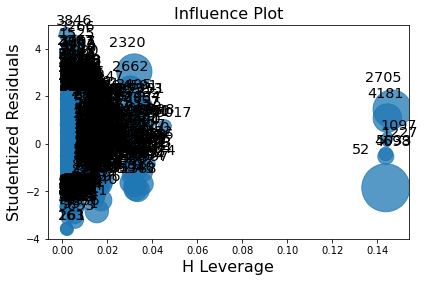

In [16]:
%%time

fig = sm.graphics.influence_plot(reg_outliers, criterion="cooks")
fig.tight_layout(pad=1.0)

In [17]:
reg_outliers_test = smf.ols('''log_renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + idade +
    cat_tempo_emprego + qt_pessoas_residencia + C(sexo) + C(tipo_renda) + C(educacao) +
    C(estado_civil) + C(tipo_residencia)''', data = df_test1).fit()

print(reg_outliers.rsquared_adj)
reg_outliers.summary()



0.3570255261184959


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        10:03:17   Log-Likelihood:                -8356.6
No. Observations:                5992   AIC:                         1.676e+04
Df Residuals:                    5969   BIC:                         1.691e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.0257      0.100     40.395      0.000       3.830       4.221
posse_de_veiculo[T.S]                   0.0064      0.029      0.222      0.824      -0.050       0.062
posse_de_imovel[T.S]                    0.1955      0.028      7.066      0.000       0.141       0.250
C(sexo)[T.M]                            0.1352      0.030      4.503      0.000       0.076       0.194
C(tipo_renda)[T.Empresário]             0.1601      0.032      5.017      0.000       0.098       0.223
C(tipo_renda)[T.Pensionista]           -0.6129      0.045    -13.625      0.000      -0.701      -0.525
C(tipo_renda)[T.Servidor público]       0.1662      0.048      3.481      0.001       0.073       0.260
C(educacao)[T.Médio]                    0.2108      0.117      1.802      0.072      -0.019       0.440
C(educacao)[T.Pós graduação]            0.3754      0.388      0.967      0.334      -0.386       1.137
C(educacao)[T.Superior completo]        0.3466      0.118      2.929      0.003       0.115       0.579
C(educacao)[T.Superior incompleto]      0.2716      0.132      2.050      0.040       0.012       0.531
C(estado_civil)[T.Separado]             1.6153      0.061     26.301      0.000       1.495       1.736
C(estado_civil)[T.Solteiro]             1.6730      0.050     33.677      0.000       1.576       1.770
C(estado_civil)[T.União]                0.0293      0.048      0.604      0.546      -0.066       0.124
C(estado_civil)[T.Viúvo]                1.5874      0.070     22.807      0.000       1.451       1.724
C(tipo_residencia)[T.Casa]             -0.0677      0.111     -0.612      0.541      -0.285       0.149
C(tipo_residencia)[T.Com os pais]      -0.0084      0.127     -0.066      0.947      -0.258       0.241
C(tipo_residencia)[T.Comunitário]      -0.1379      0.205     -0.671      0.502      -0.541       0.265
C(tipo_residencia)[T.Estúdio]          -0.2795      0.199     -1.401      0.161      -0.671       0.112
C(tipo_residencia)[T.Governamental]    -0.0447      0.129     -0.347      0.729      -0.297       0.208
qtd_filhos                             -1.5829      0.047    -34.006      0.000      -1.674      -1.492
idade                                   0.0113      0.002      6.824      0.000       0.008       0.015
cat_tempo_emprego                       0.1404      0.003     51.850      0.000       0.135       0.146
qt_pessoas_residencia                   1.5928      0.040     39.336      0.000       1.513       1.672
==============================================================================
Omnibus:                       22.499   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.447
Skew:                           0.126 

In [18]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(reg_outliers_test.fittedvalues)
df_ajuste_rsquared['y'] = df_test1['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.5058592010158154

In [40]:
# Modelo evitando a Multicolinearidade

In [60]:
reg_mult = smf.ols('''
    log_renda ~ 
    sexo + posse_de_veiculo + C(tipo_renda) + posse_de_imovel +
    C(estado_civil) + qtd_filhos + cat_tempo_emprego +  idade 
   ''', data = df_train2).fit()

print(reg_mult.rsquared_adj)
reg_mult.summary ()

0.3547714912846891


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     254.4
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        11:27:21   Log-Likelihood:                -8371.6
No. Observations:                5992   AIC:                         1.677e+04
Df Residuals:                    5978   BIC:                         1.686e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             7.4367      0.076     97.890      0.000       7.288       7.586
sexo[T.M]                             0.1225      0.030      4.093      0.000       0.064       0.181
posse_de_veiculo[T.S]                 0.0175      0.029      0.612      0.540      -0.038       0.073
C(tipo_renda)[T.Empresário]           0.1734      0.032      5.445      0.000       0.111       0.236
C(tipo_renda)[T.Pensionista]         -0.6147      0.045    -13.700      0.000      -0.703      -0.527
C(tipo_renda)[T.Servidor público]     0.1981      0.047      4.190      0.000       0.105       0.291
posse_de_imovel[T.S]                  0.1942      0.027      7.144      0.000       0.141       0.248
C(estado_civil)[T.Separado]           0.0298      0.054      0.548      0.583      -0.077       0.136
C(estado_civil)[T.Solteiro]           0.0862      0.040      2.133      0.033       0.007       0.165
C(estado_civil)[T.União]              0.0202      0.048      0.416      0.677      -0.075       0.115
C(estado_civil)[T.Viúvo]             -0.0075      0.064     -0.118      0.906      -0.133       0.118
qtd_filhos                            0.0108      0.019      0.575      0.565      -0.026       0.048
cat_tempo_emprego                     0.1401      0.003     51.767      0.000       0.135       0.145
idade                                 0.0105      0.002      6.456      0.000       0.007       0.014
==============================================================================
Omnibus:                       22.514   Durbin-Watson:                   1.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.671
Skew:                           0.123   Prob(JB):                     7.24e-06
Kurtosis:                       3.185   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(reg_mult.fittedvalues)
df_ajuste_rsquared['y'] = df_train2['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.3776007630952835

In [62]:
reg_mult_test = smf.ols('''
    log_renda ~ 
    sexo + posse_de_veiculo + C(tipo_renda) + posse_de_imovel +
    cat_tempo_emprego + C(estado_civil)+ idade + qtd_filhos
   ''', data = df_test1).fit()

print(reg_mult_test.rsquared_adj)
reg_mult_test.summary()

0.42893505598646775


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     81.42
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          3.34e-172
Time:                        11:28:40   Log-Likelihood:                -1863.2
No. Observations:                1500   AIC:                             3756.
Df Residuals:                    1485   BIC:                             3836.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             6.1975      0.130     47.527      0.000       5.942       6.453
sexo[T.M]                             0.0994      0.051      1.964      0.050       0.000       0.199
posse_de_veiculo[T.S]                -0.0304      0.048     -0.630      0.529      -0.125       0.064
C(tipo_renda)[T.Bolsista]            -2.3859      0.844     -2.827      0.005      -4.041      -0.731
C(tipo_renda)[T.Empresário]           0.0582      0.055      1.061      0.289      -0.049       0.166
C(tipo_renda)[T.Pensionista]         -0.7756      0.079     -9.807      0.000      -0.931      -0.620
C(tipo_renda)[T.Servidor público]     0.1303      0.075      1.743      0.082      -0.016       0.277
posse_de_imovel[T.S]                  0.1948      0.047      4.172      0.000       0.103       0.286
C(estado_civil)[T.Separado]           0.0277      0.091      0.305      0.760      -0.150       0.205
C(estado_civil)[T.Solteiro]           0.1348      0.070      1.930      0.054      -0.002       0.272
C(estado_civil)[T.União]             -0.0325      0.078     -0.416      0.678      -0.186       0.121
C(estado_civil)[T.Viúvo]              0.2139      0.112      1.915      0.056      -0.005       0.433
cat_tempo_emprego                     0.1379      0.005     30.044      0.000       0.129       0.147
idade                                 0.0137      0.003      4.933      0.000       0.008       0.019
qtd_filhos                            0.0377      0.033      1.155      0.248      -0.026       0.102
==============================================================================
Omnibus:                       40.272   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.526
Skew:                           0.312   Prob(JB):                     6.48e-12
Kurtosis:                       3.660   Cond. No.                     1.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
df_ajuste_rsquared = pd.DataFrame()
df_ajuste_rsquared['pred_y']= np.exp(reg_mult_test.fittedvalues)
df_ajuste_rsquared['y'] = df_test1['log_renda']
df_ajuste_rsquared[['pred_y', 'y']].corr().iloc[0,1]**2

0.5030581563367809

|Modelos|Descrição|R-Squared(base treino)|R-Squares (base test)|
|--- |--- |--- |--- |
| <center>1º Modelo<center>| <center>Original <center> | <center>0,37711<center> |<center> 0,50585 <center>|
| <center>2º Modelo<center>| <center>Sem Outliers <center> | <center> 0,37684 <center> |<center> 0,50585 <center>|
| <center>3º Modelo<center>| <center>Sem Multicolinearidade <center> | <center> 0,37760 <center> |<center> 0,50305<center>|

Verifica-se que o terceiro modelo teve melhor desempenho na base de treino, contudo um desempenho inferior na base de teste, contudo em uma percentagem bem pequena.